In [ ]:
# Importing necessary modules
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time
import functools
import IPython.display

In [ ]:
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [ ]:
# To begin, we'll enable eager execution. We can go through this strategy in the clearest and most comprehensible way if we do it quickly.
tf.executing_eagerly()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [ ]:
# Loading our image
def load_image(image_path):
  image = Image.open(image_path)
  scale = 1024/max(image.size)
  image = image.resize((round(image.size[0]*scale), round(image.size[1]*scale)), Image.ANTIALIAS)
  image = kp_image.img_to_array(image)
  # The photo array must be broadcast in such a way that it has a batch dimension.
  image = np.expand_dims(image, axis=0)
  return image

In [ ]:
path_content = '/content/9.jpeg'
path_style = '/content/5.jpeg'

In [ ]:
def imshow(image, title = None):
  # Getting rid of the batch dimension
  output = np.squeeze(image , axis=0)
  # Normalization
  output = output.astype('uint8')
  plt.imshow(output)
  if title is not None:
    plt.title(title)
  plt.imshow(output)

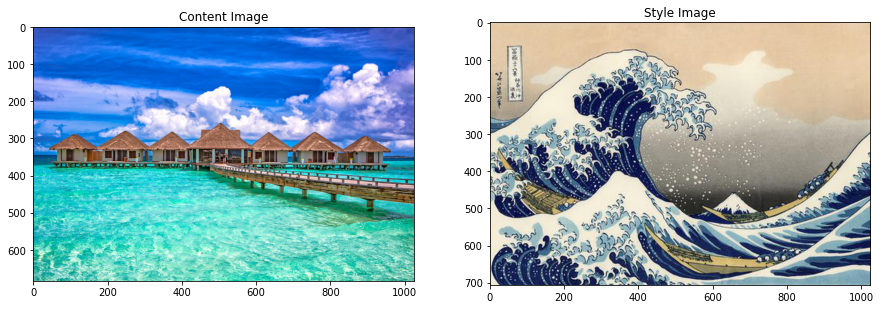

In [ ]:
# Plotting Figure
plt.figure(figsize=(15,15))
image_content = load_image(path_content).astype('uint8')
image_style = load_image(path_style).astype('uint8')
plt.subplot(1, 2, 1)
imshow(image_content, 'Content Image')
plt.subplot(1, 2, 2)
imshow(image_style, 'Style Image')
plt.show()

In [ ]:
# Loading and Processing Image
def image_process(image_path):
  img = load_image(image_path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [ ]:
# Deprocessig Image
def image_deprocess(image):
  img = image.copy()
  if len(img.shape) == 4:
    img = np.squeeze(img, 0)
  assert len(img.shape) == 3, ("Input for image deprocessing must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(img.shape) != 3:
    raise ValueError("INVALID INPUT for image deprocessing")
  #Inverse Preprocessing Steps
  img[:, :, 0] += 103.939
  img[:, :, 1] += 116.779
  img[:, :, 2] += 123.68
  img = img[:, :, ::-1]
  img = np.clip(img, 0, 255).astype('uint8')
  return img

In [ ]:
# Content Layer from which our feature maps will be retrieved
layers_content = ['block5_conv2'] 
# Style Layer
layers_style = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_layers_content = len(layers_content)
num_layers_style = len(layers_style)

In [ ]:
# Loading Model (pretrained vgg on imagenet dataset)
def getModel():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Ouput Layers for style and content
  model_outputs = [vgg.get_layer(name).output for name in layers_style] + [vgg.get_layer(name).output for name in layers_content]
  # Buliding Model
  return models.Model(vgg.input, model_outputs)

In [ ]:
# Constructing Gram Matrix
def gm(ip):
  channels = int(ip.shape[-1])
  x = tf.reshape(ip, [-1, channels])
  num = tf.shape(x)[0]
  return tf.matmul(x, x, transpose_a=True) / tf.cast(num, tf.float32)

In [ ]:
# returns Content Loss
def get_loss_content(content_base, trgt):
  return tf.reduce_mean(tf.square(trgt - content_base))

In [ ]:
# returns Style Loss
def get_loss_style(x, trgt):
  height, width, channels = x.get_shape().as_list() #for each layer
  y = gm(x)
  # ( 4 * (channels^2) * (height*width)^2 )
  return tf.reduce_mean(tf.square(y - trgt))

In [ ]:
# returns features of style and content
def get_features(m, path_content, path_style):
  #Processing and Loading Image
  style_img = image_process(path_style)
  content_img = image_process(path_content)
  # Outputs for style and content in batches
  outputs_style = m(style_img)
  outputs_content = m(content_img)
  features_style = [layer_style[0] for layer_style in outputs_style[:num_layers_style]]
  features_content = [layer_content[0] for layer_content in outputs_content[num_layers_style:]]
  return features_style, features_content

In [ ]:
# Returns total loss , style loss and content loss
def compute_loss(model, weights_loss, img, gram_features_style, features_content):
  op_model = model(img)
  x = op_model[:num_layers_style]
  y = op_model[num_layers_style:]
  score_style = 0
  score_content = 0
  # Collecting style and content losses from all layers
  for trgt_style, comb_style in zip(gram_features_style, x):
    score_style += (1.0 / float(num_layers_style)) * get_loss_style(comb_style[0], trgt_style)
  for trgt_content, comb_content in zip(features_content, y):
    score_content += (1.0 / float(num_layers_content))* get_loss_content(comb_content[0], trgt_content)
  return score_style + score_content, score_style*weights_loss, score_content*weights_loss

In [ ]:
# Computing gradient
def grad(cfg):
  with tf.GradientTape() as tape: 
    l = compute_loss(**cfg)
  total_loss = l[0]
  return tape.gradient(total_loss, cfg['img']), l

In [ ]:
def style_transfer(path_content, path_style, num_itr=1000): 
  model = getModel() 
  # Because we don't need to train any of our model's layers, we set their trainability to false.
  for layer in model.layers:
    layer.trainable = False
  # Getting features of style and content
  features_style, features_content = get_features(model, path_content, path_style)
  gram_features_style = [gm(i) for i in features_style]
  # Setting our initial image
  img = image_process(path_content)
  img = tf.Variable(img, dtype=tf.float32)
  # Setting our optimizer (Adam) with appropriate leaning rate and other values
  opt = tf.keras.optimizers.Adam(learning_rate= 1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')
  bestLoss = float('inf')
  best =  None
  # Setting style weight to 1e-2 and content weight to 1e3
  weights_loss = (1e-2, 1e3)
  # Creating a cofiguration
  cfg = {'model': model, 'weights_loss': weights_loss, 'img': img, 'gram_features_style': gram_features_style, 'features_content': features_content}
  # For Displaying
  display_interval = num_itr/10
  time_start = time.time()
  global_time = time_start
  val_min = -np.array([103.939, 116.779, 123.68])
  val_max = 255 -np.array([103.939, 116.779, 123.68])
  images = []
  for i in range(num_itr):
    grads, l = grad(cfg)
    loss, score_style, score_content = l
    opt.apply_gradients([(grads, img)])
    clipped = tf.clip_by_value(img, val_min, val_max)
    img.assign(clipped)
    end_time = time.time() 
    if loss < bestLoss:
      # Updating losses if loss is less than our best loss
      bestLoss = loss
      best = image_deprocess(img.numpy())
    if i % display_interval== 0:
      time_start = time.time()
      plot_img = img.numpy()
      plot_img = image_deprocess(plot_img)
      images.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
  print('Total time: {:.4f}s'.format(time.time() - global_time))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,j in enumerate(images):
      plt.subplot(2,5,i+1)
      plt.imshow(j)
      plt.xticks([])
      plt.yticks([])
  return best, bestLoss

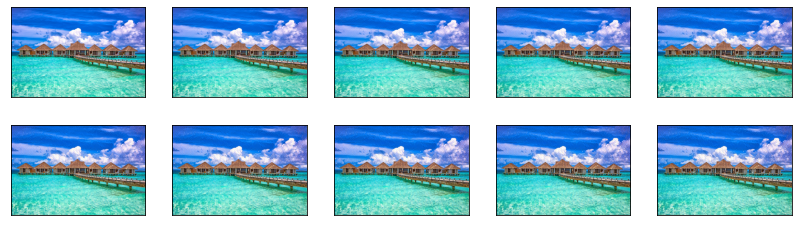

In [ ]:
best, bestLoss = style_transfer(path_content,path_style,num_itr = 50)

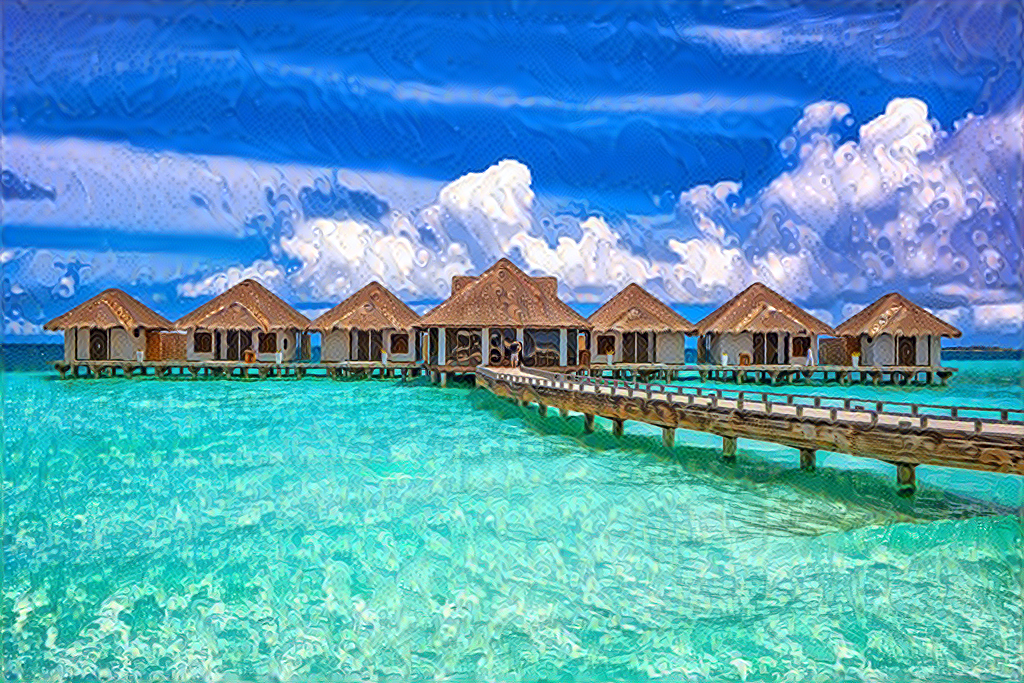

In [ ]:
Image.fromarray(best)